# Imports

In [ ]:
!pip install pycocotools
!pip install -U ffmpeg
!pip install torchmetrics

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6082 sha256=2f6d444b98bfab510380cca5a348e8e947515a08a7d77335601e2d4255a6d91b
  Stored in directory: /root/.cache/pip/wheels/56/30/c5/576bdd729f3bc062d62a551be7fefd6ed2f761901568171e4e
Successfully built ffmpeg


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import seaborn as sns
import copy
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torch.optim as optim
import torchvision
from torchvision.models.detection.ssd import SSDHead,det_utils
from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
import torchvision.transforms.functional as tf
import albumentations as A
import pycocotools
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/pothole-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pothole-detection


In [ ]:
img_dir="/kaggle/input/pothole-detection/images"
annot_dir="/kaggle/input/pothole-detection/annotations"

# Configuration

In [ ]:
#label 0 is fixed for background
classes=["background","pothole"]

num_classes=2
device="cuda" if torch.cuda.is_available() else "cpu"
batch_size=4
epochs=30
learning_rate=3e-5

model_weights_file="model.pth"

threshold=0.25
iou_threshold=0.75

In [ ]:
def parse_xml(annot_path):
    tree=ET.parse(annot_path)
    root=tree.getroot()

    width=int(root.find("size").find("width").text)
    height=int(root.find("size").find("height").text)
    boxes=[]

    for obj in root.findall("object"):
        bbox=obj.find("bndbox")
        xmin=int(bbox.find("xmin").text)
        ymin=int(bbox.find("ymin").text)
        xmax=int(bbox.find("xmax").text)
        ymax=int(bbox.find("ymax").text)

        boxes.append([xmin,ymin,xmax,ymax])

    return boxes,height,width

In [ ]:
ignore_img=[]
for annot_name in os.listdir(annot_dir):
    img_name=annot_name[:-4]+".png"
    annot_path=os.path.join(annot_dir,annot_name)
    boxes,height,width=parse_xml(annot_path)

    for box in boxes:
        if box[0]<0 or box[0]>=box[2] or box[2]>width:
            print(box[0],box[2],width)
            print("x",annot_name)
            print("*"*50)
            ignore_img.append(img_name)
        elif box[1]<0 or box[1]>=box[3] or box[3]>height:
            print(box[1],box[3],height)
            print("y",file_name)
            print("*"*50)
            ignore_img.append(img_name)

273 273 400
x potholes58.xml
**************************************************
312 401 400
x potholes214.xml
**************************************************


In [ ]:
ignore_img

['potholes58.png', 'potholes214.png']

# Custom Dataset

In [ ]:
class PotholeDetection(Dataset):
    def __init__(self,img_dir,annot_dir,transform=None):
        super().__init__()
        self.img_dir=img_dir
        self.annot_dir=annot_dir
        self.img_list=sorted([img for img in os.listdir(self.img_dir)
                              if img not in ignore_img])
        self.transform=transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self,idx):
        img_name=self.img_list[idx]
        img_path=os.path.join(self.img_dir,img_name)
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

        annot_name=img_name[:-4]+".xml"
        annot_path=os.path.join(self.annot_dir,annot_name)
        boxes,height,width=parse_xml(annot_path)
        labels=[1]*len(boxes)

        if self.transform is not None:
            transformed=self.transform(image=img,bboxes=boxes,labels=labels)
            img=transformed["image"]
            boxes=transformed["bboxes"]
            labels=transformed["labels"]

        if len(np.array(boxes).shape)!=2 or np.array(boxes).shape[-1]!=4:
            boxes=[[0.0,0.0,1.0,1.0]]
            labels=[0]

        img=img/255
        img=tf.to_tensor(img)
        img=img.to(dtype=torch.float32)
        target={}
        target["boxes"]=torch.tensor(boxes,dtype=torch.float32)
        target["labels"]=torch.tensor(labels,dtype=torch.int64)
        target["id"]=torch.tensor(idx)

        return img,target

In [ ]:
train_ds=PotholeDetection(img_dir,annot_dir,train_transform)
val_ds=PotholeDetection(img_dir,annot_dir,val_transform)

In [ ]:
from torch.utils.data import Subset

In [ ]:
idxs=list(range(len(train_ds)))

np.random.shuffle(idxs)
train_idx=idxs[:int(0.85*len(train_ds))]
val_idx=idxs[int(0.85*len(train_ds)):]

train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)

In [ ]:
len(val_ds)

100

# Pre-processing

In [ ]:
train_transform=A.Compose([A.HorizontalFlip(),
                           A.ShiftScaleRotate(rotate_limit=15,value=0,
                                              border_mode=cv2.BORDER_CONSTANT),

                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p=1),
                           A.GaussNoise(),
                           A.RandomResizedCrop(size=(480,480))], # Changed height and width to size
                          bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                   label_fields=["labels"]))

val_transform=A.Compose([A.Resize(height=480,width=480)],
                        bbox_params=A.BboxParams(format="pascal_voc",min_visibility=0.15,
                                                 label_fields=["labels"]))

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-10-a0e27ac3818f>:2: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(rotate_limit=15,value=0,


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_dl=DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=os.cpu_count(),
                    collate_fn=collate_fn,
                    pin_memory=True if device=="cuda" else False)
val_dl=DataLoader(val_ds,batch_size=batch_size,shuffle=False,num_workers=os.cpu_count(),
                  collate_fn=collate_fn,
                  pin_memory=True if device=="cuda" else False)

# Model

In [ ]:
model=ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)

in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.to(device)

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 143MB/s]


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
for params in model.backbone.features.parameters():
    params.requires_grad=False

parameters=[params for params in model.parameters() if params.requires_grad]

optimizer=optim.Adam(parameters,lr=learning_rate)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                                  patience=7, threshold=0.0001)

# Training

In [ ]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [ ]:
"""Model has been trained and its weights are stored in pothole-detection-learned-weights,
if you want to train it yourself uncomment the below code, it takes around 50 minutes."""


loss_history={"training_loss":[],
              "validation_loss":[]}

train_len=len(train_dl.dataset)
val_len=len(val_dl.dataset)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):

    training_loss=0.0
    validation_loss=0.0

    current_lr=get_lr(optimizer)

    #During training, the model expects both the input tensors, as well as a targets
    model.train()
    for imgs,targets in train_dl:
        imgs=[img.to(device) for img in imgs]
        targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

        loss_dict=model(imgs,targets)
        losses=sum(loss for loss in loss_dict.values())
        training_loss+=losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    with torch.no_grad():
        for imgs,targets in val_dl:
            imgs=[img.to(device) for img in imgs]
            targets=[{k:v.to(device) for (k,v) in d.items()} for d in targets]

            loss_dict=model(imgs,targets)
            losses=sum(loss for loss in loss_dict.values())
            validation_loss+=losses.item()


    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)

    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")


    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)

    print(f"\n{epoch+1}/{epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"*"*50)

torch.save(best_weights,model_weights_file)

Updating Best Model weights

1/30
Training Loss: 1.5860831072656554
Validation_loss: 1.3570506906509399

**************************************************
Updating Best Model weights

2/30
Training Loss: 1.3675997337693644
Validation_loss: 1.2762476587295533

**************************************************
Updating Best Model weights

3/30
Training Loss: 1.331689112986807
Validation_loss: 1.2319257259368896

**************************************************
Updating Best Model weights

4/30
Training Loss: 1.286119359424652
Validation_loss: 1.1897307968139648

**************************************************
Updating Best Model weights

5/30
Training Loss: 1.2355056266378128
Validation_loss: 1.1442141246795654

**************************************************
Updating Best Model weights

6/30
Training Loss: 1.1969774582458008
Validation_loss: 1.0982962298393248

**************************************************
Updating Best Model weights

7/30
Training Loss: 1.177130471326106

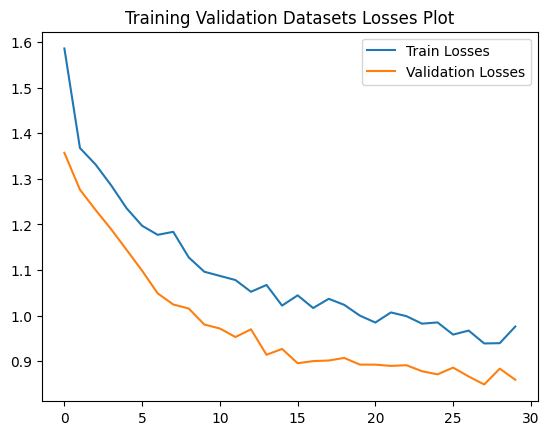

In [ ]:
sns.lineplot(x=range(epochs),y=loss_history["training_loss"],label="Train Losses");
sns.lineplot(x=range(epochs),y=loss_history["validation_loss"],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");

# Evaluation

In [ ]:
model_weights_pth="/content/model.pth"
model=ssd300_vgg16()

in_channels=det_utils.retrieve_out_channels(model.backbone,(480,480))
num_anchors=model.anchor_generator.num_anchors_per_location()
model.head=SSDHead(in_channels=in_channels,num_anchors=num_anchors,
                   num_classes=num_classes)

model.load_state_dict(torch.load(model_weights_pth,map_location=device))
model.to(device)

<ipython-input-26-fb7c47b868d2>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_weights_pth,map_location=device))


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
from torchvision.ops import box_iou

def evaluate_model(model, data_loader, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives

    with torch.no_grad():
        for imgs, targets in data_loader:
            imgs = [img.to(device) for img in imgs]
            outputs = model(imgs)

            for i in range(len(outputs)):
                pred_boxes = outputs[i]["boxes"].cpu()
                pred_scores = outputs[i]["scores"].cpu()
                pred_labels = outputs[i]["labels"].cpu()

                # Filter out predictions below score threshold or background class
                keep = (pred_scores > score_threshold) & (pred_labels == 1)
                pred_boxes = pred_boxes[keep]

                true_boxes = targets[i]["boxes"].cpu()
                true_labels = targets[i]["labels"].cpu()
                true_boxes = true_boxes[true_labels == 1]

                if len(pred_boxes) == 0:
                    fn += len(true_boxes)
                    continue

                if len(true_boxes) == 0:
                    fp += len(pred_boxes)
                    continue

                ious = box_iou(pred_boxes, true_boxes)
                max_iou, matched_gt = ious.max(dim=1)

                matched_gt_flags = [False] * len(true_boxes)
                for j, iou_val in enumerate(max_iou):
                    if iou_val >= iou_threshold and not matched_gt_flags[matched_gt[j]]:
                        tp += 1
                        matched_gt_flags[matched_gt[j]] = True
                    else:
                        fp += 1

                fn += matched_gt_flags.count(False)

    # precision = tp / (tp + fp + 1e-6)
    # recall = tp / (tp + fn + 1e-6)
    # f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return precision, recall, f1

evaluate_model(model, val_dl)  # or use test_dl if you want to evaluate on test set

Precision: 0.7907
Recall:    0.8101
F1 Score:  0.8233


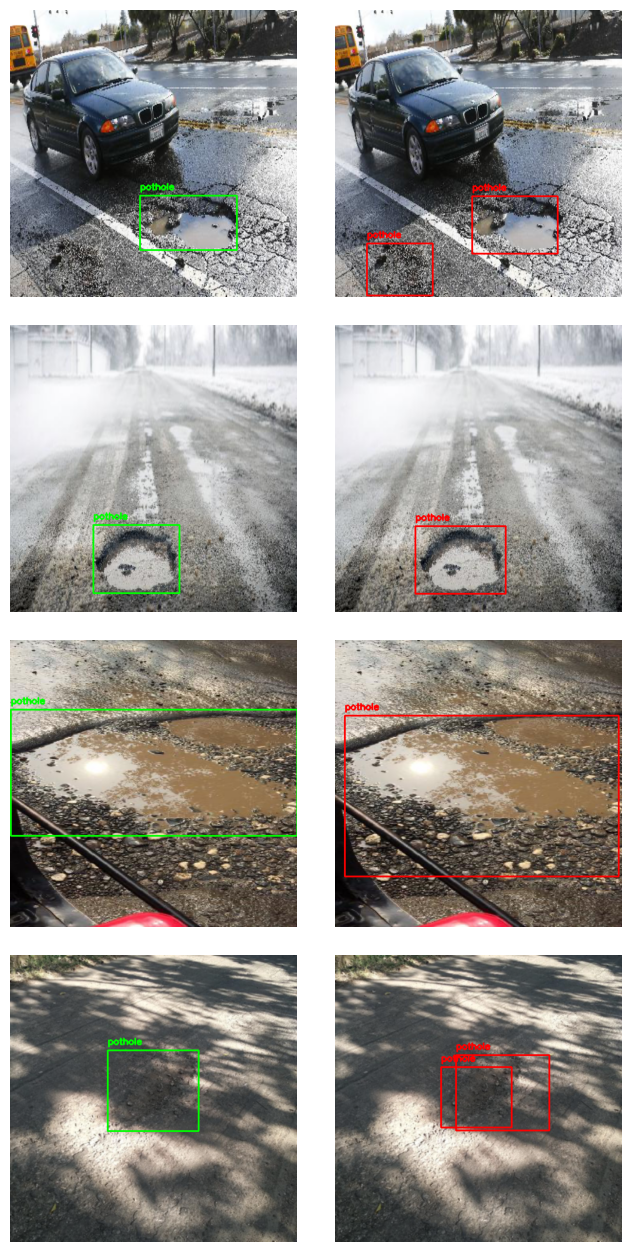

In [ ]:
fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,targets=next(iter(val_dl))
model.eval()
with torch.no_grad():
    output=model([img.to(device) for img in imgs])

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    prediction=output[idx]

    #real bounding boxes
    output_img=show_bbox(img,targets[idx],color=(0,255,0));
    axes[i,0].imshow(output_img);
    axes[i,0].axis("off");

    #predicted bounding box
    predict=preprocess_bbox(prediction)
    output_img=show_bbox(img,predict,color=(255,0,0));
    axes[i,1].imshow(output_img);
    axes[i,1].axis("off");

plt.savefig("4.png")